In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import numpy as np

In [2]:
main_dir = "./../"
results_dir = os.path.join(main_dir, "results")
figs_dir = os.path.join(main_dir, "figs")

In [3]:
wd = os.path.join(main_dir, "ANN_results/params_explore")

In [5]:
diff_params = [
    "current",
    
    "no_layer", "2_layer", "5_layer", "10_layer",
    
    "1_neurons", "2_neurons", "3_neurons", "4_neurons", "5_neurons",
    "6_neurons", "7_neurons", "8_neurons", "9_neurons",
    "11_neurons", "20_neurons", "25_neurons", "50_neurons", "100_neurons",
    
    "sigmoid", "elu", "selu", "exp", "tanh", "softplus", "softmax", "softsign",
    
    "MSE_loss_func", "poisson_loss_func", "kld_loss_func", 
    
    "initialiser_he_norm", "initialiser_he_uni", "initialiser_rand_norm", "initialiser_rand_uni",
    "initialiser_trunc_norm", "initialiser_ones", "initialiser_zeros", "initialiser_glorot_normal",
    
    "optimiser_SGD", "optimiser_RMSProp", "optimiser_adadelta", "optimiser_adagrad",
    "optimiser_adamax", "optimiser_nadam", "optimiser_ftrl",
    
    "learning_rate_0.001", "learning_rate_0.005", "learning_rate_0.05", "learning_rate_0.1",
    "learning_rate_0.25", "learning_rate_0.5", "learning_rate_1.0",
    
    "dropout_0.1", "dropout_0.25", "dropout_0.33", "dropout_0.5", "dropout_0.75",
    
    "L1_regular", "L2_regular", "L1L2_regular", "ortho_rows_regular", "ortho_cols_regular",
    "all_L1_regular", "all_L2_regular", "all_L1L2_regular",
]

In [6]:
p = re.compile("""(\d+)_hist_epoch_(\d+)_train_acc_(\d+\.\d+)\.csv""")

versions, seed_ids, n_epochs, accs = [[], [], [], []]

for param in diff_params:
    param_dir = os.path.join(wd, param)
    hists_dir = os.path.join(param_dir, "hists")
    hists = os.listdir(hists_dir)
    for hist in hists:
        #print(hist)
        try:
            m = p.match(hist)
            if m:
                g = m.groups()
                seed, epoch, acc = g
        except:
            print("ERROR")
        
        df = pd.read_csv(os.path.join(hists_dir, hist))
       # print(seed, epoch, acc)
        versions.append(param)
        seed_ids.append(seed)
        n_epochs.append(int(epoch))
        accs.append(df.loc[int(epoch), "val_accuracy"])
        #break
    #break



In [7]:
master_df = pd.DataFrame(list(zip(versions, seed_ids, n_epochs, accs)),
              columns=['version','seed', 'f_epoch', 'acc'])

In [8]:
len(master_df)

6500

In [12]:
figs_dir

'./../figs'

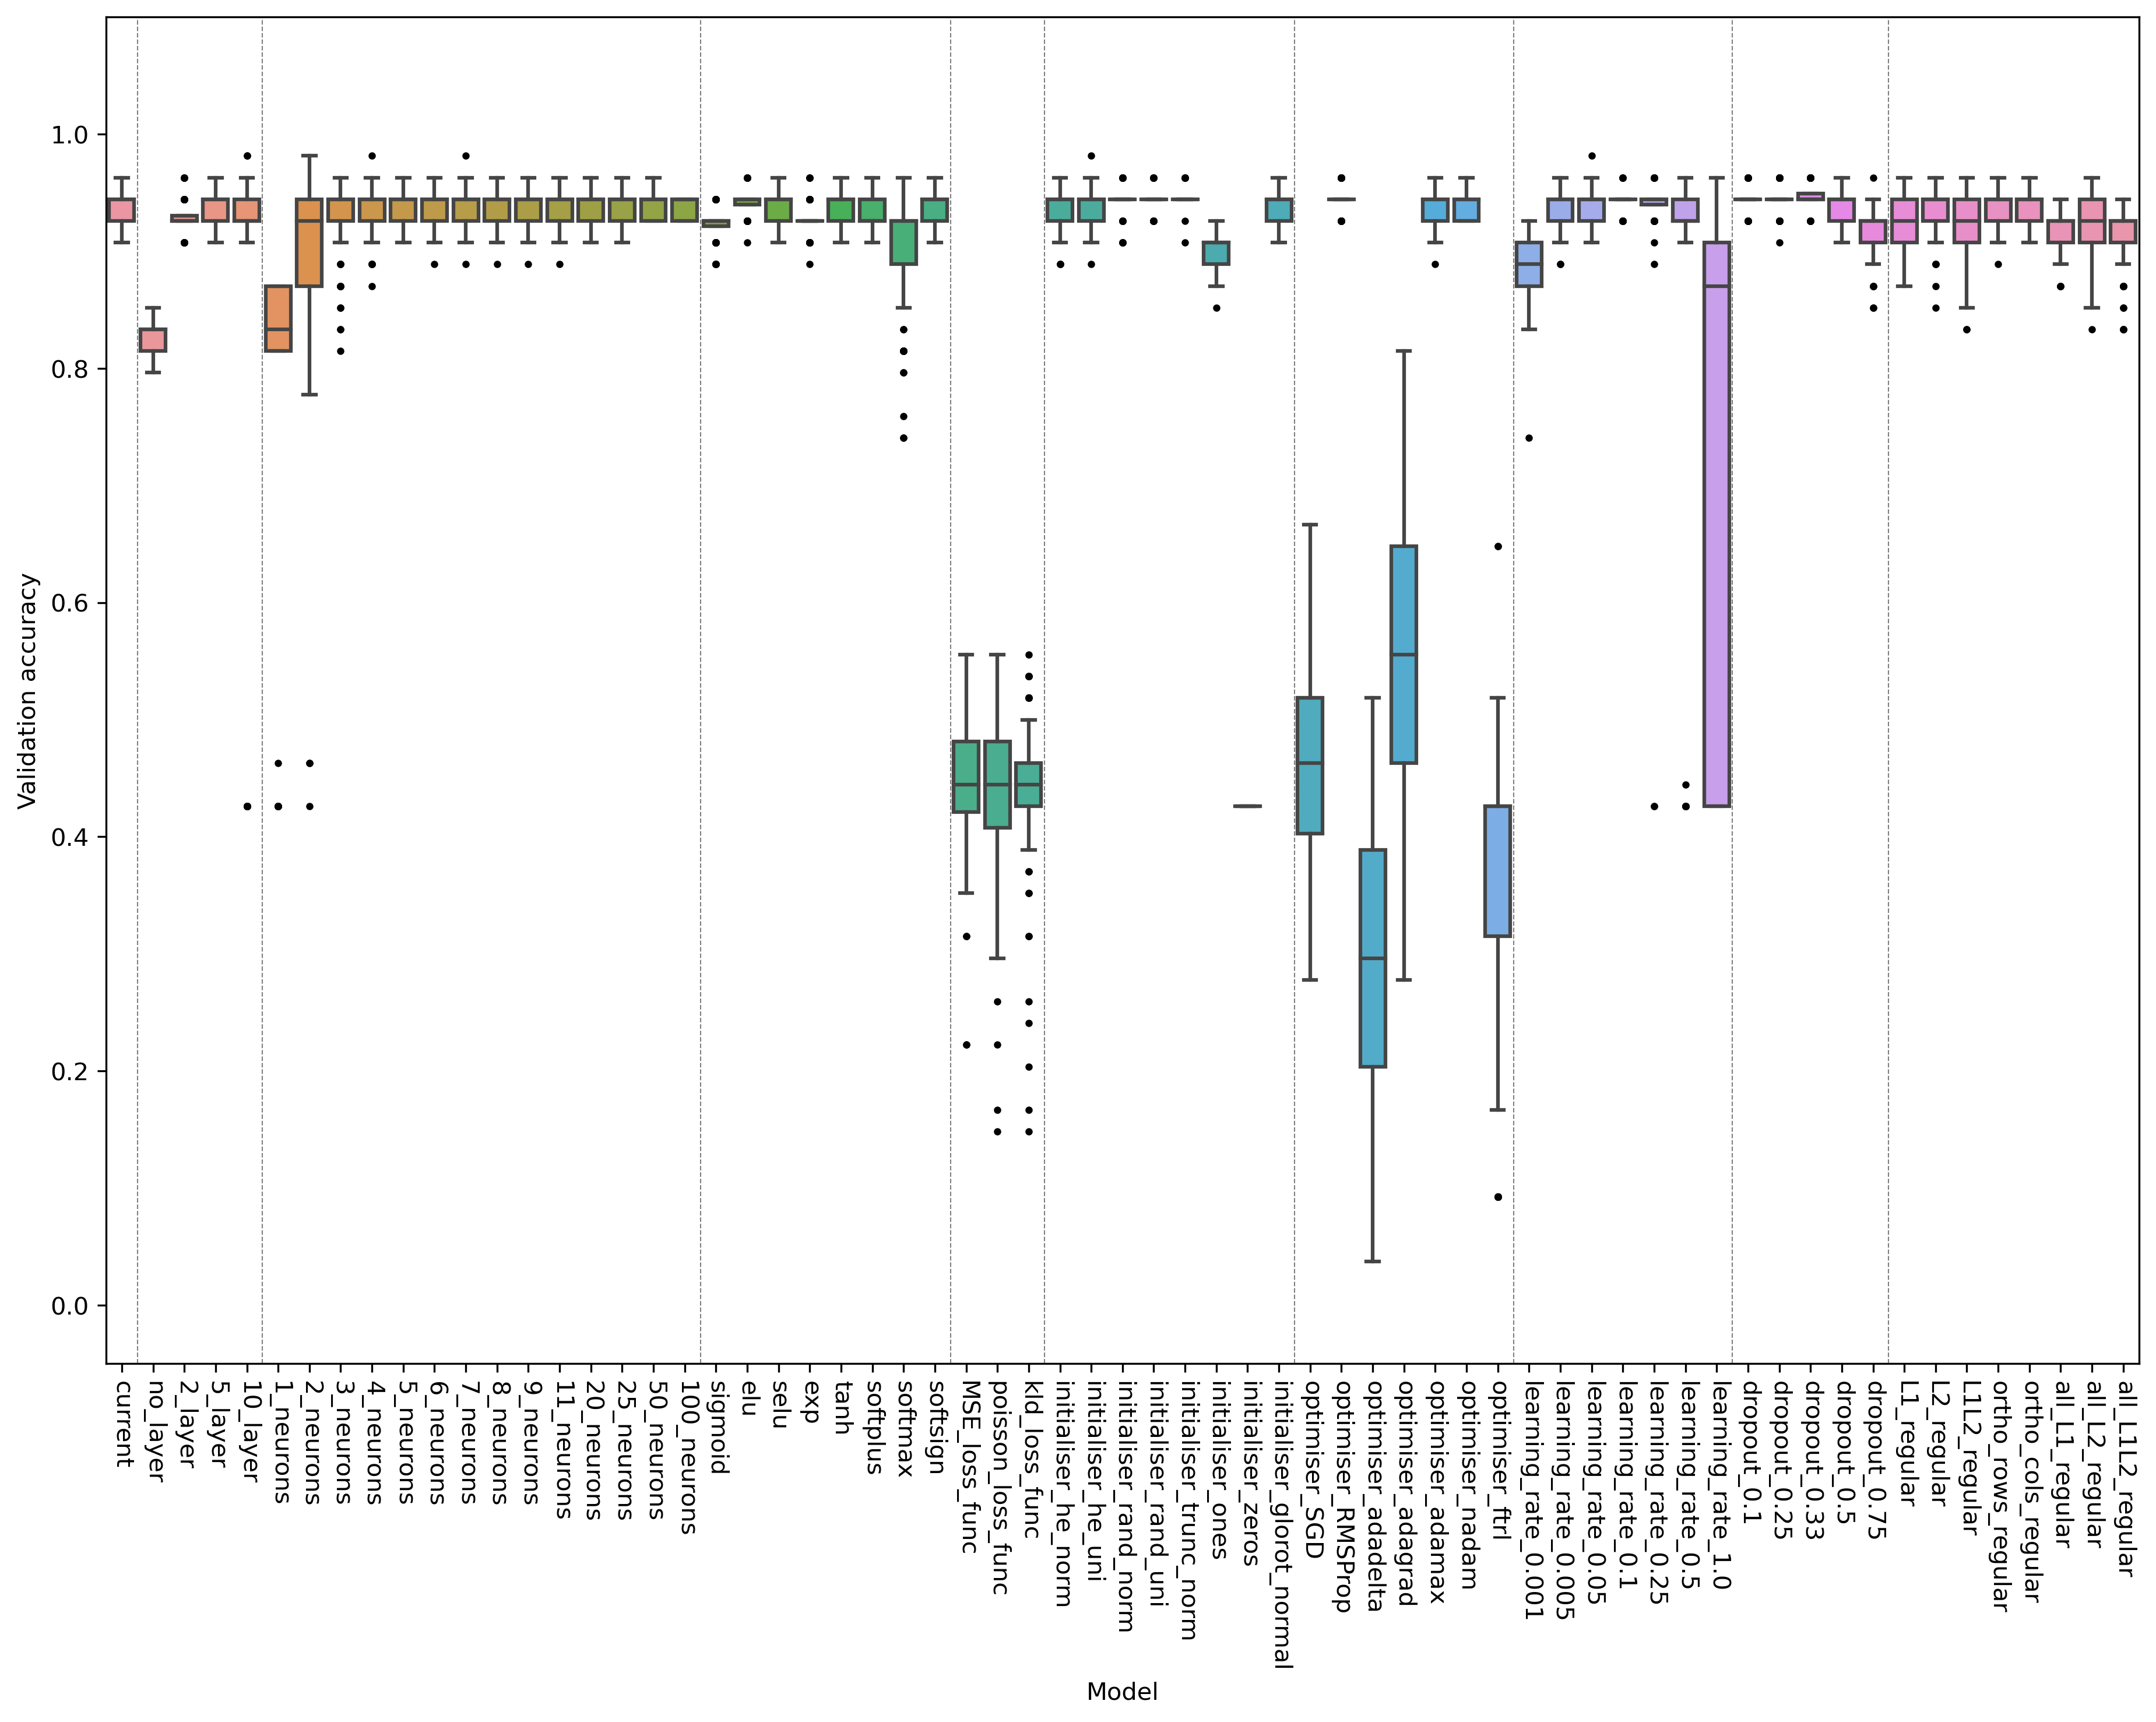

In [13]:
plt.figure(figsize = (15, 10), dpi = 300)

flierprops = dict(marker='o', markerfacecolor= "k", markersize=2,
                  linestyle='none', color="k", markeredgecolor='k')

# Create the boxplot with different colors
sns.boxplot(x='version', y='acc', data=master_df, flierprops = flierprops)

plt.ylim(-0.05, 1.1)
plt.ylabel("Validation accuracy")
plt.xticks(rotation=-90)
plt.xlabel("Model")

plt.axvline(x=0.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=4.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=18.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=26.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=29.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=37.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=44.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=51.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=56.5, linestyle='--', color="grey", linewidth = 0.5)
plt.savefig(os.path.join(figs_dir, "MLP_ablation_results2.png"))
plt.show()

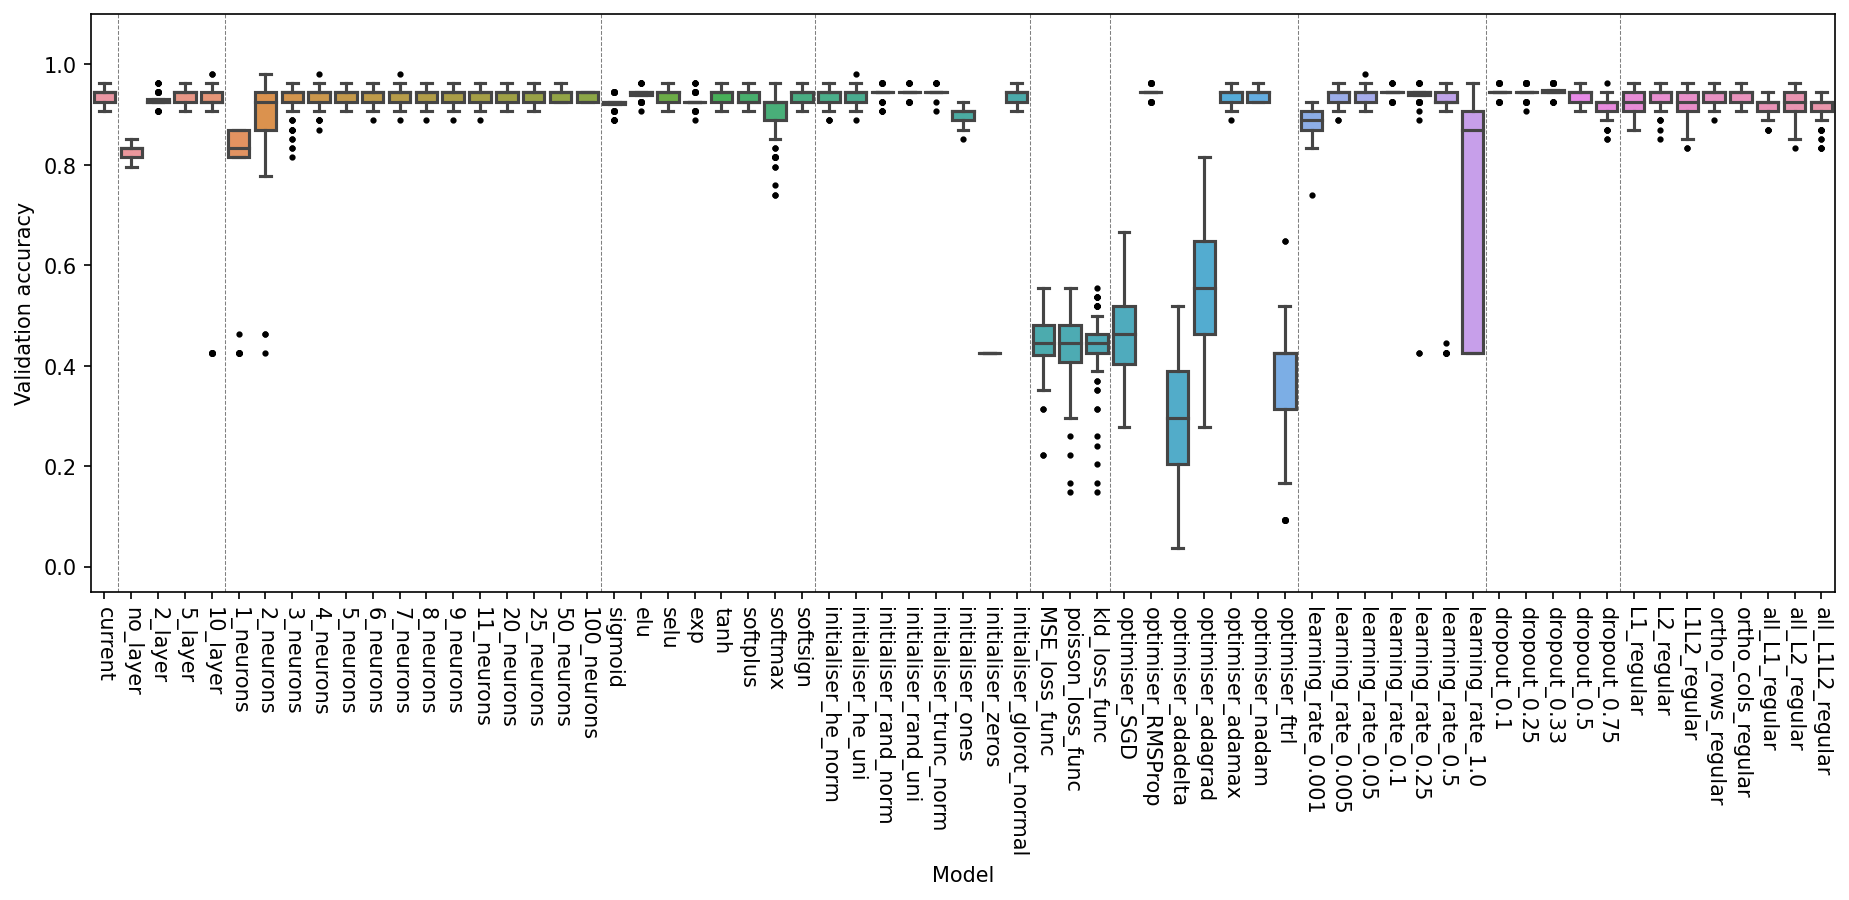

In [126]:
plt.figure(figsize = (15, 5), dpi = 150)

flierprops = dict(marker='o', markerfacecolor= "k", markersize=2,
                  linestyle='none', color="k", markeredgecolor='k')

# Create the boxplot with different colors
sns.boxplot(x='version', y='acc', data=master_df, flierprops = flierprops)

plt.ylim(-0.05, 1.1)
plt.ylabel("Validation accuracy")
plt.xticks(rotation=-90)
plt.xlabel("Model")

plt.axvline(x=0.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=4.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=18.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=26.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=34.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=37.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=44.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=51.5, linestyle='--', color="grey", linewidth = 0.5)
plt.axvline(x=56.5, linestyle='--', color="grey", linewidth = 0.5)
#plt.savefig(os.path.join(figs_dir, "ML_CV_rev.png"))
plt.show()

In [82]:
# Define your groups and the reference group
groups = master_df['version'].unique()
reference_group = 'current'

# Perform comparisons and collect p-values
p_values = []
comparisons = []
diff_means = []

for group in groups:
    if group != reference_group:
        current_group_data = master_df[master_df['version'] == reference_group]['acc']
        other_group_data = master_df[master_df['version'] == group]['acc']
        
        ref_mean = master_df[master_df['version'] == reference_group]['acc'].mean()
        other_mean = master_df[master_df['version'] == group]['acc'].mean()

        diff_mean = 100*(other_mean-ref_mean)
        
        t_stat, p_val = stats.ttest_ind(current_group_data, other_group_data, equal_var=False)  # Welch's t-test
        p_values.append(p_val)
        comparisons.append((reference_group, group))
        diff_means.append(diff_mean)

# Apply Benjamini-Hochberg correction

p_values = np.array(p_values)
sort_indices = np.argsort(p_values)
sorted_p_values = p_values[sort_indices]
sorted_comparisons = np.array(comparisons)[sort_indices]
sorted_diff_means = np.array(diff_means)[sort_indices]

   
adjusted_p_values_bools, adjusted_p_values = statsmodels.stats.multitest.fdrcorrection(p_values, alpha=0.05, method='indep', is_sorted=False)


# Print results
for i, (group1, group2) in enumerate(sorted_comparisons):
    if adjusted_p_values[i] < 0.05:
        if sorted_diff_means[i] > 0:
            print(f"Comparison {group1} vs {group2}: p={round(sorted_p_values[i], 4)}, adjusted p={round(adjusted_p_values[i], 4)}, mean_diff = {round(sorted_diff_means[i], 4)}")

Comparison current vs dropout_0.33: p=0.0, adjusted p=0.0005, mean_diff = 0.7963
Comparison current vs dropout_0.25: p=0.0009, adjusted p=0.0095, mean_diff = 0.6111
Comparison current vs dropout_0.1: p=0.0012, adjusted p=0.0003, mean_diff = 0.5556
Comparison current vs optimiser_RMSProp: p=0.0026, adjusted p=0.0, mean_diff = 0.537
Comparison current vs initialiser_rand_norm: p=0.0239, adjusted p=0.0, mean_diff = 0.4074
Comparison current vs learning_rate_0.1: p=0.0459, adjusted p=0.0, mean_diff = 0.3148
Comparison current vs elu: p=0.3837, adjusted p=0.0007, mean_diff = 0.1481
Comparison current vs optimiser_nadam: p=0.4819, adjusted p=0.002, mean_diff = 0.1296
Comparison current vs dropout_0.5: p=0.5437, adjusted p=0.0, mean_diff = 0.1111
Comparison current vs 11_neurons: p=0.6541, adjusted p=0.0368, mean_diff = 0.0926


/tmp/1492720.1.all.q/ipykernel_128081/1568739736.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(current_group_data, other_group_data, equal_var=False)  # Welch's t-test


In [83]:
for i, (group1, group2) in enumerate(sorted_comparisons):
    if adjusted_p_values[i] < 0.05:
        #if sorted_diff_means[i] > 0:
        print(f"Comparison {group1} vs {group2}: p={round(sorted_p_values[i], 4)}, adjusted p={round(adjusted_p_values[i], 4)}, mean_diff = {round(sorted_diff_means[i], 4)}")

Comparison current vs initialiser_zeros: p=0.0, adjusted p=0.0, mean_diff = -51.3518
Comparison current vs no_layer: p=0.0, adjusted p=0.0, mean_diff = -11.0
Comparison current vs poisson_loss_func: p=0.0, adjusted p=0.0, mean_diff = -50.3148
Comparison current vs kld_loss_func: p=0.0, adjusted p=0.0, mean_diff = -50.0
Comparison current vs optimiser_adadelta: p=0.0, adjusted p=0.0001, mean_diff = -64.5
Comparison current vs optimiser_SGD: p=0.0, adjusted p=0.004, mean_diff = -47.2593
Comparison current vs L1L2_regular: p=0.0, adjusted p=0.0, mean_diff = -1.9259
Comparison current vs all_L2_regular: p=0.0, adjusted p=0.0, mean_diff = -1.7037
Comparison current vs dropout_0.33: p=0.0, adjusted p=0.0005, mean_diff = 0.7963
Comparison current vs 10_layer: p=0.0, adjusted p=0.0, mean_diff = -8.9259
Comparison current vs 2_neurons: p=0.0, adjusted p=0.0376, mean_diff = -4.1481
Comparison current vs learning_rate_0.5: p=0.0003, adjusted p=0.0413, mean_diff = -5.7037
Comparison current vs dro

In [95]:
current_vs = [el[1] for el in sorted_comparisons]
sorted_p_values = [round(el, 4) for el in sorted_p_values]
sorted_diff_means = [round(el, 2) for el in sorted_diff_means]

In [96]:
test_results = pd.DataFrame(list(zip(current_vs, sorted_p_values, sorted_diff_means)),
              columns=['version','FDR', 'diff'])

In [100]:
test_results[test_results.version.str.contains("layer")]

,version,FDR,diff
1,no_layer,0.0000,-11.00
22,2_layer,0.0000,-1.00
24,10_layer,0.0000,-8.93
51,5_layer,0.4234,-0.15


In [102]:
test_results[test_results.version.str.contains("neuron")].sort_values("version")

,version,FDR,diff
53,100_neurons,0.4881,-0.11
59,11_neurons,0.6541,0.09
12,1_neurons,0.0000,-14.93
60,20_neurons,0.6810,0.07
62,25_neurons,0.8325,-0.04
25,2_neurons,0.0000,-4.15
31,3_neurons,0.0020,-1.06
45,4_neurons,0.2397,-0.28
63,50_neurons,0.9092,-0.02
55,5_neurons,0.5423,-0.13


In [103]:
test_results[test_results.version.isin(["sigmoid", "elu", "selu", "exp", "tanh", "softplus", "softmax", "softsign"])]

,version,FDR,diff
16,sigmoid,0.0000,-1.52
17,softmax,0.0000,-3.98
19,exp,0.0000,-1.17
27,softplus,0.0002,-0.69
35,softsign,0.0212,-0.41
43,selu,0.1478,-0.26
49,elu,0.3837,0.15
50,tanh,0.4088,-0.15


In [104]:
test_results[test_results.version.str.contains("initialiser")].sort_values("version")

,version,FDR,diff
61,initialiser_glorot_normal,0.7879,-0.06
48,initialiser_he_norm,0.3650,-0.20
44,initialiser_he_uni,0.2086,-0.26
8,initialiser_ones,0.0000,-3.96
36,initialiser_rand_norm,0.0239,0.41
33,initialiser_rand_uni,0.0051,0.44
26,initialiser_trunc_norm,0.0001,0.59
0,initialiser_zeros,0.0000,-51.35


In [105]:
test_results[test_results.version.str.contains("dropout")].sort_values("version")

,version,FDR,diff
30,dropout_0.1,0.0012,0.56
29,dropout_0.25,0.0009,0.61
23,dropout_0.33,0.0000,0.80
56,dropout_0.5,0.5437,0.11
15,dropout_0.75,0.0000,-2.02


In [106]:
test_results[test_results.version.isin(["MSE_loss_func", "poisson_loss_func", "kld_loss_func"])]

,version,FDR,diff
2,MSE_loss_func,0.0,-49.81
3,poisson_loss_func,0.0,-50.31
4,kld_loss_func,0.0,-50.00


In [107]:
test_results[test_results.version.str.contains("optimiser")].sort_values("version")

,version,FDR,diff
32,optimiser_RMSProp,0.0026,0.54
6,optimiser_SGD,0.0000,-47.26
5,optimiser_adadelta,0.0000,-64.50
9,optimiser_adagrad,0.0000,-38.83
57,optimiser_adamax,0.6016,0.11
7,optimiser_ftrl,0.0000,-59.24
52,optimiser_nadam,0.4819,0.13


In [108]:
test_results[test_results.version.str.contains("learning_rate")].sort_values("version")

,version,FDR,diff
10,learning_rate_0.001,0.0000,-4.98
37,learning_rate_0.005,0.0395,-0.44
40,learning_rate_0.05,0.0584,-0.33
39,learning_rate_0.1,0.0459,0.31
47,learning_rate_0.25,0.2673,-0.83
28,learning_rate_0.5,0.0003,-5.70
13,learning_rate_1.0,0.0000,-24.37


In [109]:
test_results[test_results.version.isin(["L1_regular", "L2_regular", "L1L2_regular", "ortho_rows_regular", "ortho_cols_regular", "all_L1_regular", "all_L2_regular", "all_L1L2_regular"])]

,version,FDR,diff
11,all_L1_regular,0.0000,-2.11
14,all_L1L2_regular,0.0000,-2.56
18,L1L2_regular,0.0000,-1.93
20,L1_regular,0.0000,-1.48
21,all_L2_regular,0.0000,-1.70
34,ortho_rows_regular,0.0201,-0.46
38,L2_regular,0.0400,-0.46
58,ortho_cols_regular,0.6219,-0.09
